In [62]:
import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
#import esmvalcore.preprocessor
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

matplotlib.rcParams.update({'font.size': 14})

In [63]:
### options

assessment_period = ['1991', '2015']

In [64]:
ens_mems = [x.split('/')[9] for x in glob.glob('/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/*/AERmon/ztp')]
def get_ds(variable, table='Amon', grid='gn'):
    ds_list = []
    for es in ens_mems:
        path = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/{e}/{t}/{v}/{g}/latest/'.format(e=es, t=table,v=variable, g=grid)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS

DS = get_ds(variable='ztp', table='AERmon', grid='gn')
DS = DS.sel(time=slice(assessment_period[0], assessment_period[1]))
DS_UKESM = DS.mean(dim='Ensemble_member').mean('x').groupby('time.month').mean('time')
DS_UKESM_ES = get_ds(variable='ztp', table='AERmon', grid='gn').sel(time=slice(assessment_period[0], assessment_period[1])).mean('x').groupby('time.month').mean('time')
DS_UKESM_E1 = get_ds(variable='ztp', table='AERmon', grid='gn').isel(Ensemble_member=0).sel(time=slice(assessment_period[0], assessment_period[1])).mean('x')

In [65]:
CESM_ens_mems = [1, 2, 3]

ds_list = []
for ens_mem in CESM_ens_mems:
    CESM_path = '/gws/nopw/j04/cpom/aduffey/Tropopause/CMIP6/CESM2WACCM/historical/r{}i1p1f1'.format(ens_mem)
    CESM_file = '/ztp_AERmon_CESM2-WACCM_historical_r{}i1p1f1_gn_185001-201412.nc'.format(ens_mem)
    file =  CESM_path + CESM_file
    ds = rename_cmip6(xr.open_dataset(file))
    ds_list.append(ds)
DS_CESM = xr.concat(ds_list, dim='Ensemble_member')
DS_CESM = DS_CESM.sel(time=slice(assessment_period[0], assessment_period[1])).mean(dim='Ensemble_member').mean('x').groupby('time.month').mean('time')

DS_CESM_ES = xr.concat(ds_list, dim='Ensemble_member').sel(time=slice(assessment_period[0], assessment_period[1])).mean('x').groupby('time.month').mean('time')
DS_CESM_E1 = ds_list[0].sel(time=slice(assessment_period[0], assessment_period[1])).mean('x')

/home/users/a_duffey/.conda/envs/main2/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'ztp' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/users/a_duffey/.conda/envs/main2/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'ztp' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/users/a_duffey/.conda/envs/main2/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'ztp' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [66]:
#DS_UKESM.ztp.plot.contourf()
#DS_CESM.ztp.plot.contourf()

In [67]:
mean_trop_U, max_trop_U, min_trop_U = (DS_UKESM.mean(dim='month').ztp/1000).load(), (DS_UKESM.max(dim='month').ztp/1000).load(), (DS_UKESM.min(dim='month').ztp/1000).load()
mean_trop_C, max_trop_C, min_trop_C = (DS_CESM.mean(dim='month').ztp/1000).load(), (DS_CESM.max(dim='month').ztp/1000).load(), (DS_CESM.min(dim='month').ztp/1000).load()

Annual variation of ensemble means (monthly resolution)


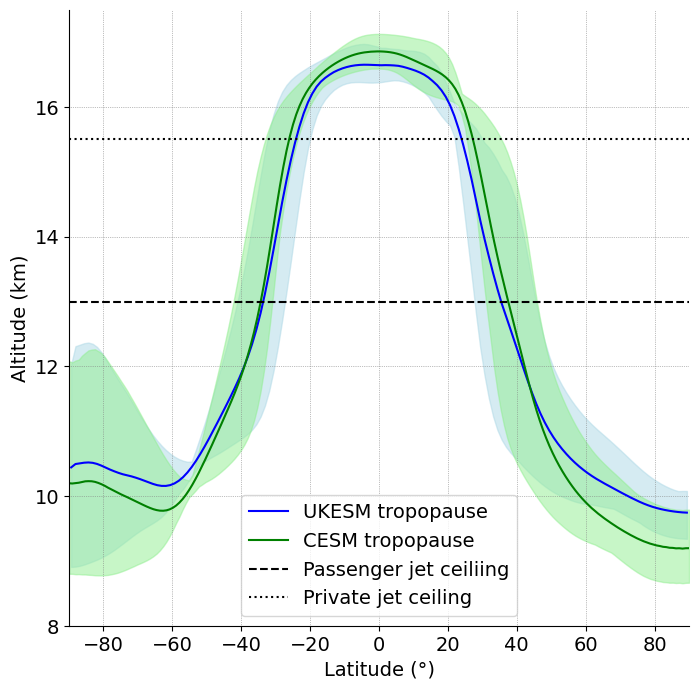

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
t_col = 'black'

mean_trop_U.plot(ax=ax, c='blue')
mean_trop_C.plot(ax=ax, c='green')
ax.fill_between(max_trop_U.y.values, min_trop_U.values, max_trop_U.values, 
                color='lightblue', alpha=0.5)
ax.fill_between(max_trop_C.y.values, min_trop_C.values, max_trop_C.values, 
                color='lightgreen', alpha=0.5)

ax.axhline(15.5, c='black', ls='dotted')
ax.axhline(13, c='black', ls='dashed')

ax.plot([], [], c='blue', label='UKESM tropopause')
ax.plot([], [], c='green', label='CESM tropopause')
ax.plot([], [], c='black', ls='dashed', label='Passenger jet ceiliing')
ax.plot([], [], c='black', ls='dotted',  label='Private jet ceiling')
#ax.plot([], [], c='red', ls = '--', label='"high altitude"')
ax.legend(loc='lower center')

ax.set_xlabel('Latitude (°)')
ax.set_ylabel('Altitude (km)')
ax.set_xlim([-90, 90])
ax.set_ylim([8, 17.5])
ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)

ax.spines[['right', 'top']].set_visible(False)
print('Annual variation of ensemble means (monthly resolution)')
plt.savefig('Figures/UKESM_CESM_mean_and_annual_spread.jpg', dpi=350)

In [69]:
## now repeat, with reanalyses added

### downloaded reanalysis zonal mean troppause heights from Hoffman & Spang
# https://acp.copernicus.org/articles/22/4019/2022/acp-22-4019-2022-assets.html
# use the WMO thermal 1st tropopause (as in ztp calc)
# https://datapub.fz-juelich.de/slcs/tropopause/data/projects/zonal_mean/README.txt

# NB we include ERA5 even though it doesn't include the 1990-2000 period. 
from scipy.interpolate import griddata

root = '/gws/nopw/j04/cpom/aduffey/Tropopause/zonal_means_HoffmanSpang/'
dir = root+reanalysis+'/'

dfs_all = []
reanalyses = ['ERA5', 'ERAi', 'MERRA2', 'NCEP','NCEP2']

for reanalysis in reanalyses:
    dir = root+reanalysis+'/'
    dfs_reanalysis = []
    for file in os.listdir(dir):
        year = file.split('_')[-2]
        month = file.split('_')[-1].split('.')[0]
        if int(year) >= int(assessment_period[0]) and int(year) <= int(assessment_period[1]):
            df = pd.read_csv(dir+file, 
                        delimiter=" ",
                        skiprows=14,
                        header=None)
            df = df.iloc[:, 0:3] 
            df.columns = ['time [s]',
                          'latitude [deg]',
                          'tropopause height (mean) [km]']
            grid_lat_new = np.arange(-90, 90.1, 0.1)
            regridded_ztp = griddata(df['latitude [deg]'], df['tropopause height (mean) [km]'], grid_lat_new, method='linear')
            df_regridded = pd.DataFrame({'Latitude_deg':grid_lat_new,
                                         'ztp_km':regridded_ztp})
            df_regridded['Year'] = year
            df_regridded['Month'] = month
            df_regridded['Reanalysis'] = reanalysis
            dfs_reanalysis.append(df_regridded)
    df_reanalysis = pd.concat(dfs_reanalysis)
    dfs_all.append(df_reanalysis)
DF = pd.concat(dfs_all)
DF['Month'] = [int(x) for x in DF['Month']]
DF['Year'] = [int(x) for x in DF['Year']]

In [70]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

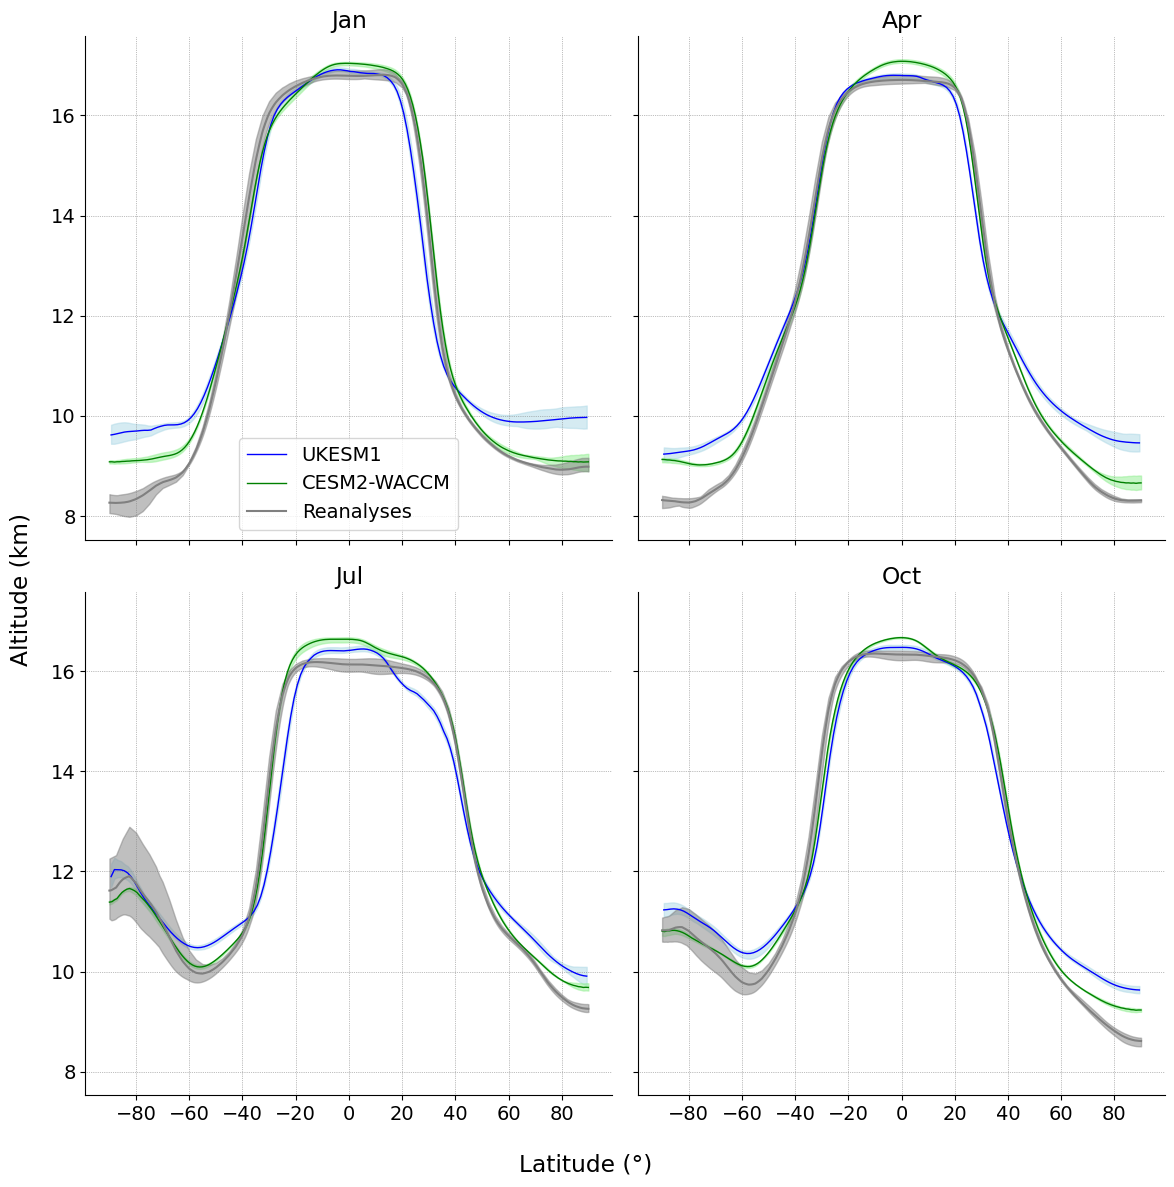

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
months = [1, 4, 7, 10]
titles = ['Jan', 'Apr', 'Jul', 'Oct']
i=0

for ax in axs.flatten():
        
    month = months[i]
    ds = DS_UKESM.sel(month=month)
    ax.plot(ds.y.values, ds.ztp.values*0.001, label='UKESM1', color='blue', lw=1)
    ds_max = DS_UKESM_ES.sel(month=month).max(dim='Ensemble_member')
    ds_min = DS_UKESM_ES.sel(month=month).min(dim='Ensemble_member')
    ax.fill_between(ds_max.y.values, ds_min.ztp.values*0.001, ds_max.ztp.values*0.001, 
                color='lightblue', alpha=0.5)
    
    ds = DS_CESM.sel(month=month)
    ax.plot(ds.y.values, ds.ztp.values*0.001, label='CESM2-WACCM', color='green', lw=1)
    ds_max = DS_CESM_ES.sel(month=month).max(dim='Ensemble_member')
    ds_min = DS_CESM_ES.sel(month=month).min(dim='Ensemble_member')
    ax.fill_between(ds_max.y.values, ds_min.ztp.values*0.001, ds_max.ztp.values*0.001, 
                color='lightgreen', alpha=0.5)

    df = DF[DF['Month']==month]
    df = df[['Reanalysis', 'Latitude_deg', 'ztp_km']].groupby(['Reanalysis', 'Latitude_deg']).mean().reset_index()
    df_max = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).max().reset_index()
    df_min = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).min().reset_index()
    df_mean = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).mean().reset_index()
    ax.fill_between(df_max['Latitude_deg'], df_min['ztp_km'], df_max['ztp_km'], 
                color='gray', alpha=0.5)
    ax.plot(df_mean['Latitude_deg'], df_mean['ztp_km'], color='gray', label='Reanalyses')
    ax.set_xticks(np.arange(-80, 85, 20))
    if i == 0:
        ax.legend()
    ax.set_title(titles[i])
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
    i=i+1
fig.supylabel('Altitude (km)')
fig.supxlabel('Latitude (°)')
plt.tight_layout()
plt.savefig('Figures/Tropopause_UKESMandCESM_vs_reanalyses.jpg', dpi=300)

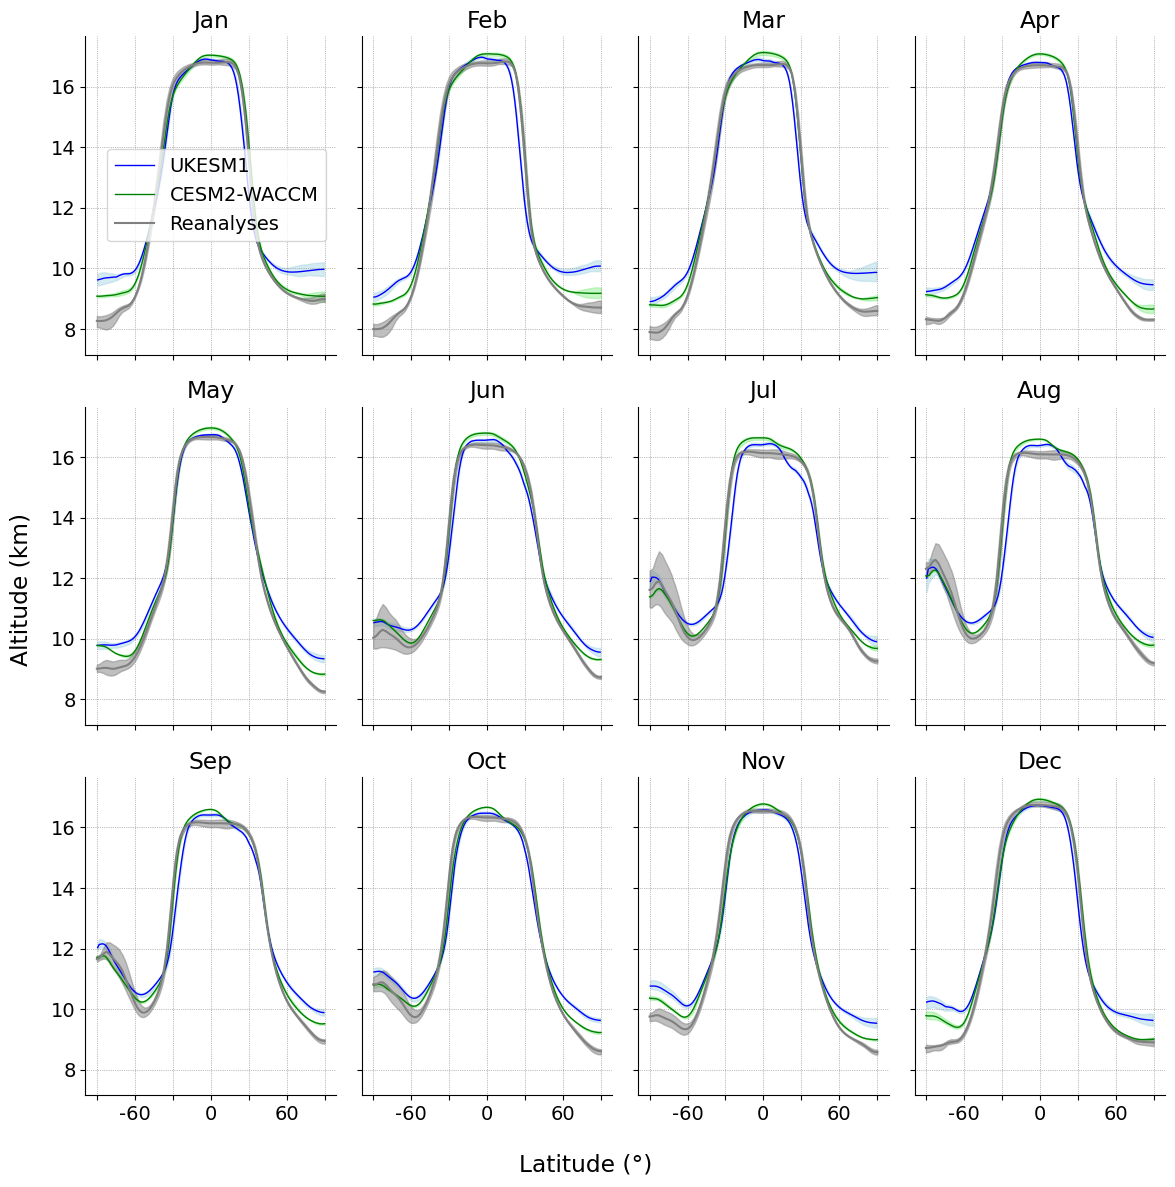

In [72]:
### now repeat, this time showing min max range of members:
fig, axs = plt.subplots(3, 4, figsize=(12, 12), sharex=True, sharey=True)

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
titles = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
i=0

for ax in axs.flatten():
        
    month = months[i]
    ds = DS_UKESM.sel(month=month)
    ax.plot(ds.y.values, ds.ztp.values*0.001, label='UKESM1', color='blue', lw=1)
    ds_max = DS_UKESM_ES.sel(month=month).max(dim='Ensemble_member')
    ds_min = DS_UKESM_ES.sel(month=month).min(dim='Ensemble_member')
    ax.fill_between(ds_max.y.values, ds_min.ztp.values*0.001, ds_max.ztp.values*0.001, 
                color='lightblue', alpha=0.5)
    
    ds = DS_CESM.sel(month=month)
    ax.plot(ds.y.values, ds.ztp.values*0.001, label='CESM2-WACCM', color='green', lw=1)
    ds_max = DS_CESM_ES.sel(month=month).max(dim='Ensemble_member')
    ds_min = DS_CESM_ES.sel(month=month).min(dim='Ensemble_member')
    ax.fill_between(ds_max.y.values, ds_min.ztp.values*0.001, ds_max.ztp.values*0.001, 
                color='lightgreen', alpha=0.5)

    df = DF[DF['Month']==month]
    df = df[['Reanalysis', 'Latitude_deg', 'ztp_km']].groupby(['Reanalysis', 'Latitude_deg']).mean().reset_index()
    df_max = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).max().reset_index()
    df_min = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).min().reset_index()
    df_mean = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).mean().reset_index()
    ax.fill_between(df_max['Latitude_deg'], df_min['ztp_km'], df_max['ztp_km'], 
                color='gray', alpha=0.5)
    ax.plot(df_mean['Latitude_deg'], df_mean['ztp_km'], color='gray', label='Reanalyses')
    ax.set_xticks(np.arange(-90, 95, 30))
    ax.set_xticklabels(['', '-60', '', '0', '' , '60', ''])
    if i == 0:
        ax.legend()
    ax.set_title(titles[i])
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
    i=i+1
fig.supylabel('Altitude (km)')
fig.supxlabel('Latitude (°)')
plt.tight_layout()
plt.savefig('Figures/Tropopause_UKESMandCESM_vs_reanalyses_fullyear.jpg', dpi=300)

In [73]:
## also plot the year-to-year variability for one member, and for MERRA2:

month = 1

DS_UKESM_E1_m = DS_UKESM_E1.where(DS_UKESM_E1.time.dt.month == month, drop=True)
DS_CESM_E1_m = DS_CESM_E1.where(DS_CESM_E1.time.dt.month == month, drop=True)

mean_trop_U, max_trop_U, min_trop_U = (DS_UKESM_E1_m.mean(dim='time').ztp/1000).load(), (DS_UKESM_E1_m.max(dim='time').ztp/1000).load(), (DS_UKESM_E1_m.min(dim='time').ztp/1000).load()
mean_trop_C, max_trop_C, min_trop_C = (DS_CESM_E1_m.mean(dim='time').ztp/1000).load(), (DS_CESM_E1_m.max(dim='time').ztp/1000).load(), (DS_CESM_E1_m.min(dim='time').ztp/1000).load()

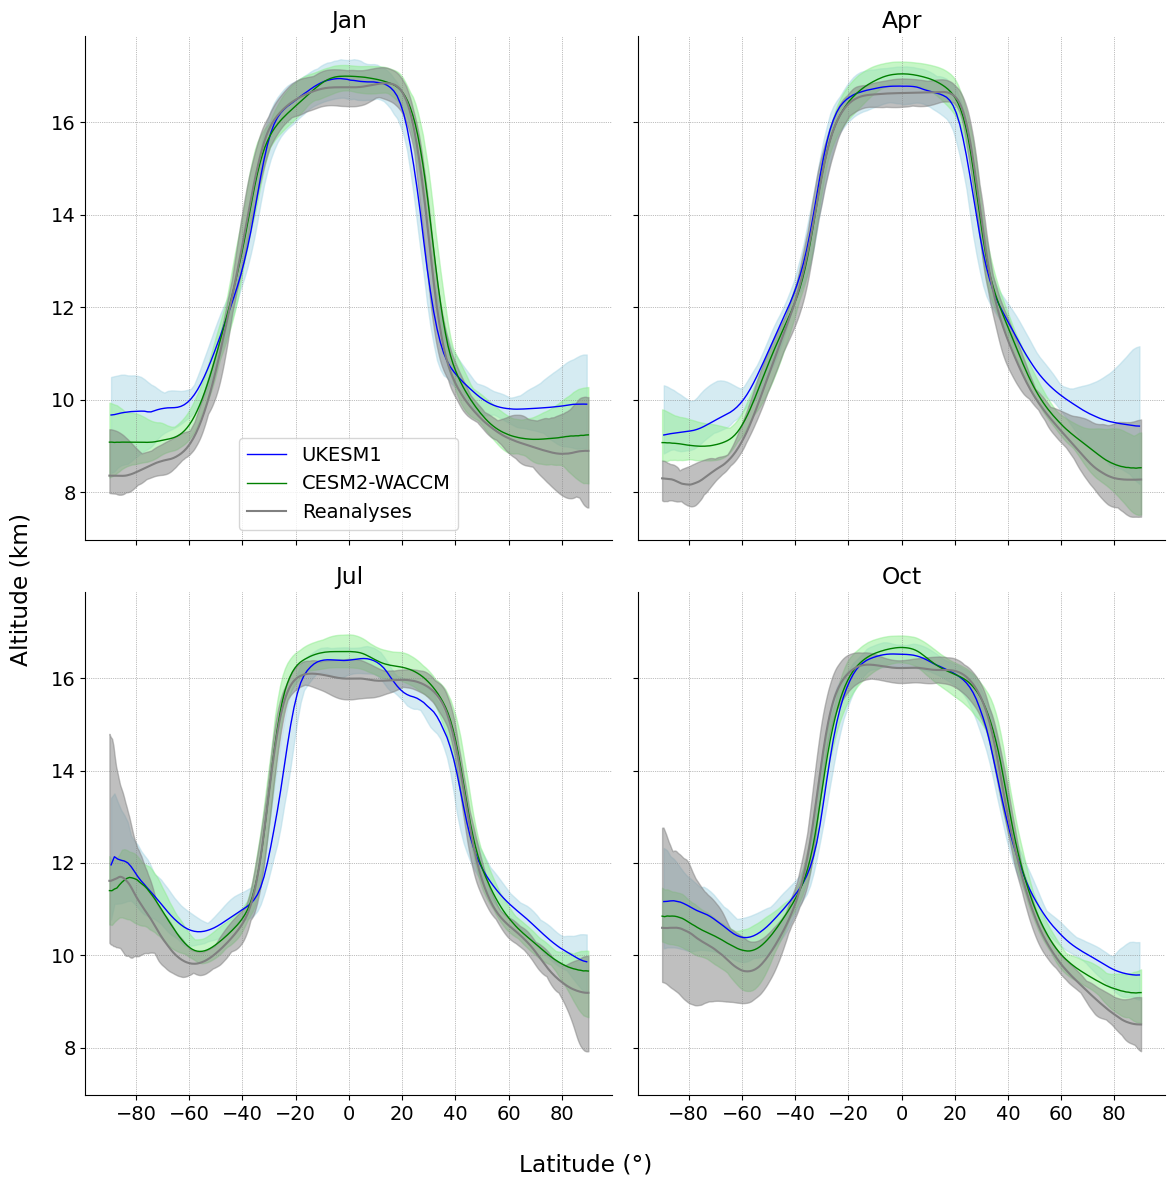

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
months = [1, 4, 7, 10]
titles = ['Jan', 'Apr', 'Jul', 'Oct']
i=0
reanalysis = 'MERRA2' # fairly central estimate and has full timeseries

for ax in axs.flatten():
        
    month = months[i]

    DS_UKESM_E1_m = DS_UKESM_E1.where(DS_UKESM_E1.time.dt.month == month, drop=True)
    DS_CESM_E1_m = DS_CESM_E1.where(DS_CESM_E1.time.dt.month == month, drop=True)
    
    mean_trop_U, max_trop_U, min_trop_U = (DS_UKESM_E1_m.mean(dim='time').ztp/1000).load(), (DS_UKESM_E1_m.max(dim='time').ztp/1000).load(), (DS_UKESM_E1_m.min(dim='time').ztp/1000).load()
    mean_trop_C, max_trop_C, min_trop_C = (DS_CESM_E1_m.mean(dim='time').ztp/1000).load(), (DS_CESM_E1_m.max(dim='time').ztp/1000).load(), (DS_CESM_E1_m.min(dim='time').ztp/1000).load()

    ax.plot(mean_trop_U.y.values, mean_trop_U.values, label='UKESM1', color='blue', lw=1)
    ax.fill_between(mean_trop_U.y.values, min_trop_U.values, max_trop_U.values, 
                color='lightblue', alpha=0.5)

    ax.plot(mean_trop_C.y.values, mean_trop_C.values, label='CESM2-WACCM', color='green', lw=1)
    ax.fill_between(mean_trop_C.y.values, min_trop_C.values, max_trop_C.values, 
                color='lightgreen', alpha=0.5)

    df = DF[DF['Month']==month]
    df = df[df['Reanalysis']==reanalysis]
    df_max = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).max().reset_index()
    df_min = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).min().reset_index()
    df_mean = df[['Latitude_deg', 'ztp_km']].groupby(['Latitude_deg']).mean().reset_index()
    ax.fill_between(df_max['Latitude_deg'], df_min['ztp_km'], df_max['ztp_km'], 
                color='gray', alpha=0.5)
    ax.plot(df_mean['Latitude_deg'], df_mean['ztp_km'], color='gray', label='{} renalysis'.format(reanalysis))
    

    
    ax.set_xticks(np.arange(-80, 85, 20))
    if i == 0:
        ax.legend()
    ax.set_title(titles[i])
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
    i=i+1
fig.supylabel('Altitude (km)')
fig.supxlabel('Latitude (°)')
plt.tight_layout()

plt.savefig('Figures/Tropopause_y2y_variabitliy_UKESMandCESM_vs_reanalyses.jpg', dpi=300)